In [2]:
#imports here
import pandas as pd
import numpy as np
import seaborn as sns

#Suppress warnings. 
import warnings

import matplotlib.pyplot as plt

#EDA tools
from datetime import datetime
from dateutil.parser import parser
import string
import re

#SKlearn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model, metrics

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

#ignores warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/anaconda2/envs/ga/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Train Data EDA

In [3]:
train_columns = ['Date',
                 #'Address',
                 'Species',
                 'Block',
                 #'Street',
                 'Trap',
                 #'AddressNumberAndStreet',
                 'Latitude',
                 'Longitude',
                 #'AddressAccuracy',
                 'NumMosquitos',
                 'WnvPresent']

In [4]:
train = pd.read_csv('../input/train.csv',usecols=train_columns)

In [90]:
train['Date'] = pd.to_datetime(train['Date']) # convert dtype to date
train['Species'] = train['Species'].str.strip('CULEX ')

# baseline accuracy; it means that 95% accuracy just by answering '0' 
print("Baseline Acc.: ",train['WnvPresent'].value_counts()[0]/train['WnvPresent'].value_counts().sum())

Baseline Acc.:  0.9475537787930707


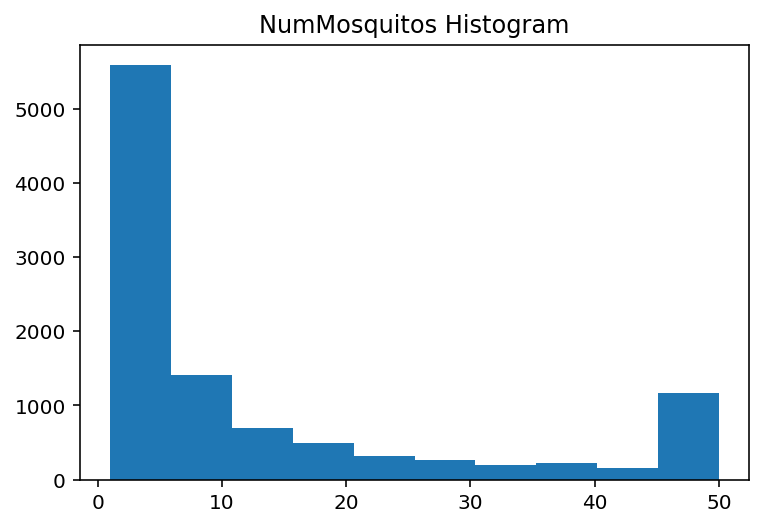

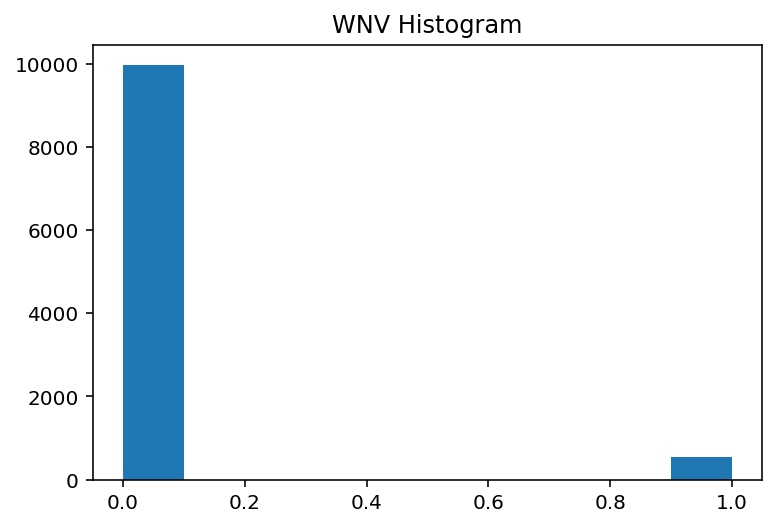

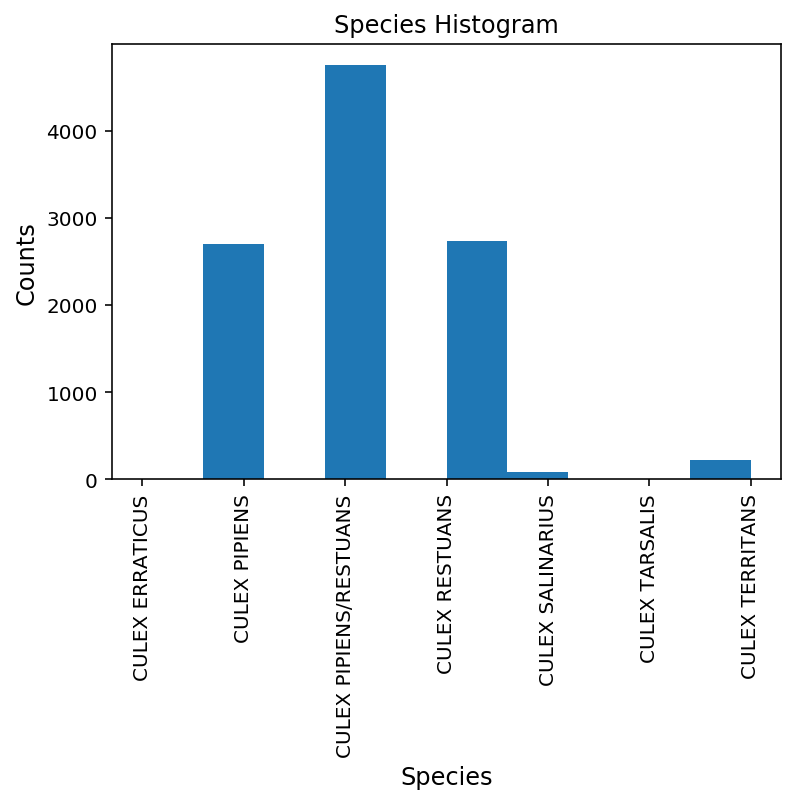

In [6]:
plt.hist(x=train['NumMosquitos'])
plt.title('NumMosquitos Histogram')
plt.show()
plt.hist(x=train['WnvPresent'])
plt.title('WNV Histogram')
plt.show()
plt.hist(x=train['Species'].sort_values(),orientation='vertical')
plt.xticks(x=train['Species'], rotation='vertical')
plt.title('Species Histogram')
plt.xlabel('Species',size='large')
plt.ylabel('Counts',size='large')
plt.show()

### Test Data EDA

In [7]:
test_cols = [#'Id',
             'Date',
             #'Address',
             'Species',
             'Block',
             #'Street',
             'Trap',
             #'AddressNumberAndStreet',
             'Latitude',
             'Longitude',
             #'AddressAccuracy'
            ]

In [8]:
test = pd.read_csv('../input/test.csv',usecols=test_cols)

In [87]:
test['Date'] = pd.to_datetime(test['Date']) # convert date dtype to date
test['Species'] = test['Species'].str.strip('CULEX ')

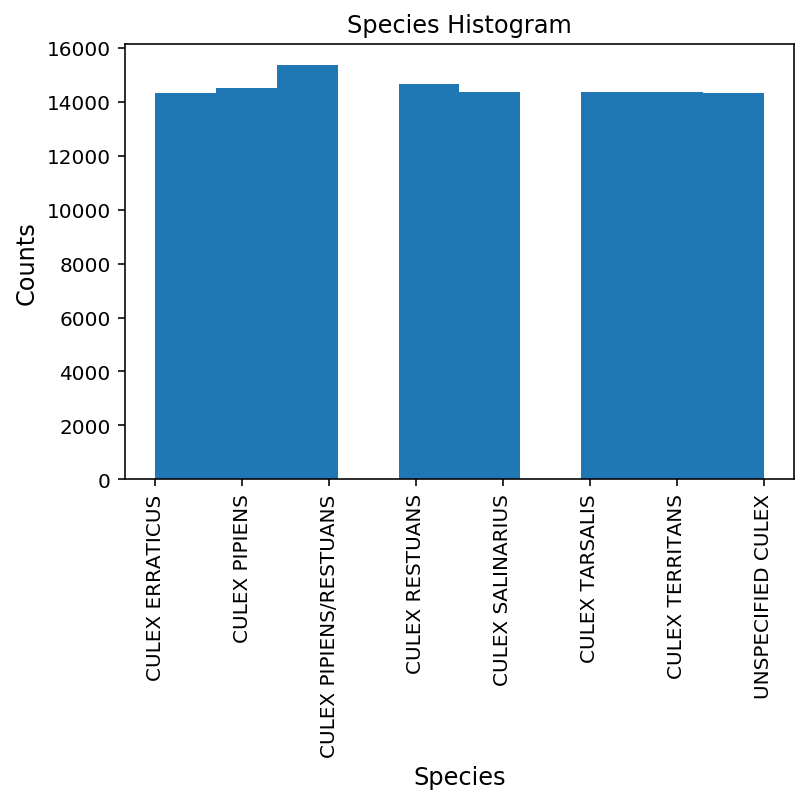

In [10]:
plt.hist(x=test['Species'].sort_values(),orientation='vertical')
plt.xticks(x=test['Species'], rotation='vertical')
plt.title('Species Histogram')
plt.xlabel('Species',size='large')
plt.ylabel('Counts',size='large')
plt.show()

### Weather data EDA

In [80]:
weather_cols = ['Station',
                   'Date',
                   'Tmax',
                   'Tmin',
                   'Tavg',
                   'Depart',
                   'DewPoint',
                   'WetBulb',
                   'Heat',
                   'Cool',
                   'Sunrise',
                   'Sunset',
                   'CodeSum',
                   #'Depth',
                   'SnowFall',
                   'PrecipTotal',
                   'SeaLevel',
                   'ResultSpeed',
                   'ResultDir',
                   'AvgSpeed'
                  ]

In [81]:
weather = pd.read_csv('../input/weather.csv',
                      usecols=weather_cols,
                      na_values={'Tavg':'M',
                                 'WetBulb':'M',
                                 'Heat':'M',
                                 'Cool':'M',
                                 'Sunrise':'-',
                                 'Sunset':'-',
                                 'PercipTotal':'M',
                                 'Depart':'M',
                                 'SeaLevel':'M',
                                 'AvgSpeed':'M',
                                 'SnowFall':'M'
                                }
                     )

In [82]:
# converting weather codes to one-hot encoded columns
code_list = list(set([i[j] for i in [title.split() for title in pd.get_dummies(weather.CodeSum).columns.tolist()] for j in range(len(i))]))

for code in code_list:
    weather[code] = [1 if code in weather.CodeSum[i] else 0 for i in range(weather.CodeSum.shape[0])]

In [83]:
def fill_w_other(df,columns,fill='2'):
    '''
    Takes a null cell's value (default station 2) and fills it with the station 1 value from the same date
    '''
    null_index = df[columns[0]][df[columns[0]].isnull() == True].index
    try:
        for c in columns:
            if fill == '2':
                df.loc[null_index,c] = [df.loc[i-1,c] if i%2 != 0 and df.loc[i,'Date'] == df.loc[i-1,'Date'] else df.loc[i,c] for i in null_index]
            elif fill == '1':
                df.loc[null_index,c] = [df.loc[i+1,c] if i%2 == 0 and df.loc[i,'Date'] == df.loc[i+1,'Date'] else df.loc[i,c] for i in null_index]
            print("Nulls remaining in {}: ".format(c), df[c][df[c].isnull() == True].count())
    except:
        print('Oops!')
        pass
    
def stat_fill(df,columns,stat='median'):
    '''
    takes list of column names, changes data type to float and converts remaining null values to a summary stat value.
    '''
    for c in columns:
        try:
            df[c] = df[c].copy().astype(dtype='float') # converts to float
        except:
            print(c,df[c].dtype)
        null_index = df[c][df[c].isnull() == True].index
        if df[c][df[c].isnull() == True].count() > 0:
            if stat == 'median':
                df.loc[null_index,c] = [df[c].median() for i in null_index]
            elif stat == 'mean':
                df.loc[null_index,c] = [df[c].mean() for i in null_index]
            else:
                print('Wrong stat!')
            print("Nulls remaining in {}: ".format(c), df[c][df[c].isnull() == True].count())

In [84]:
# converts "Trace" percipitation to very small non-zero float
trace_index = weather['PrecipTotal'][weather['PrecipTotal'] == '  T'].index
weather.loc[trace_index,'PrecipTotal'] = [0.001 for i in trace_index] 

fill_w_other(weather,['Sunrise','Sunset','SnowFall',
                      'SeaLevel','PrecipTotal',
                      'Depart','WetBulb','AvgSpeed']) # fills in station 2 missing values with station 1

stat_fill(weather,['Tavg','WetBulb','Heat','Cool','PrecipTotal']) # convert remaining nulls to median value
stat_fill(weather,['Depart'],stat='mean') # convert nulls to mean departure value

weather['Date'] = pd.to_datetime(weather['Date']) # convert date dtype to date

weather[['Tavg_C','DewPoint_C']]=weather[['Tavg','DewPoint']].apply(lambda x: (x-32)*(5/9)).round(1) # Farenheit to Celcius for RH calculation

#Calculation Relative Humidity
weather['RH1'] = ((np.exp(17.67*weather['DewPoint_C']/(243.5+weather['DewPoint_C'])))*100 /
                 (np.exp((17.67*weather['Tavg_C']/(243.5+weather['Tavg_C']))))).round(1)
weather['RH2'] = ((6.112*np.exp(17.502*weather['WetBulb_C']/(240.97+weather['WetBulb_C']))
                   -0.6687451584*(1.0+0.00115*weather['WetBulb_C'])*(weather['DewPoint_C']-weather['WetBulb_C']))*100 / 
                 (6.112*np.exp(17.502*weather['DewPoint_C']/(240.97+weather['DewPoint_C'])))).round(1)

Nulls remaining in Sunrise:  0
Nulls remaining in Sunset:  0
Nulls remaining in SnowFall:  0
Nulls remaining in SeaLevel:  0
Nulls remaining in PrecipTotal:  0
Nulls remaining in Depart:  0
Nulls remaining in WetBulb:  0
Nulls remaining in AvgSpeed:  0


In [85]:
weather[weather.isnull() == True].count()

# To do: apply weather data to nearest to trap. add to train data, based on nearest station

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
SnowFall       0
PrecipTotal    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
TSRA           0
GR             0
SQ             0
MIFG           0
TS             0
BCFG           0
VCTS           0
RA             0
SN             0
FU             0
HZ             0
BR             0
FG             0
DZ             0
FG+            0
VCFG           0
Tavg_C         0
DewPoint_C     0
RH             0
dtype: int64

In [ ]:
'''
I'd still like to try to go back and apply nearest weather station but having trouble getting the spatial element.
'''
weather = weather.groupby('Date')[[weather.columns.tolist()[2:]]].mean().reset_index(level=0)

### Spray Data EDA

In [15]:
df_spray = pd.read_csv('../input/spray.csv')

In [16]:
# Converting date and makeing columns for year and month
spray['Date'] = pd.to_datetime(spray['Date'])
spray['Year'] = spray['Date'].dt.year
spray['Month'] = spray['Date'].dt.month

Date            10
Time          8583
Latitude     12887
Longitude    13007
dtype: int64

In [ ]:
df_spray.isnull().sum()

In [ ]:
spray = df_spray.copy()

In [ ]:
spray['Time']

### Sample Submission data EDA

In [ ]:
df_sample = pd.read_csv('/Users/guillermogonzalez/ga/evan_github/input/sampleSubmission.csv')

In [ ]:
df_sample.nunique()

### Date Ranges

In [ ]:
print('          Min          Max')
print('train =  ',df_train['Date'].min(),' ', df_train['Date'].max())
print('test =   ',df_test['Date'].min(),' ', df_test['Date'].max())
print('weather =',df_weather['Date'].min(),' ', df_weather['Date'].max())
print('spray =  ',df_spray['Date'].min(),' ', df_spray['Date'].max())